In [1]:
import torch
from VSSParamsNNTorch import NetworkParams
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from scipy.special import gamma

In [2]:
network = NetworkParams()
param_num = sum(p.numel() for p in network.parameters())
print(f"模型参数量：{param_num}")

for param in network.parameters():
    print(param)
    print(param.shape)

模型参数量：2246
Parameter containing:
tensor(1.0000, requires_grad=True)
torch.Size([])
Parameter containing:
tensor(-8.9000e-05, requires_grad=True)
torch.Size([])
Parameter containing:
tensor(-0.7040, requires_grad=True)
torch.Size([])
Parameter containing:
tensor(-0.0440, requires_grad=True)
torch.Size([])
Parameter containing:
tensor(0.1130, requires_grad=True)
torch.Size([])
Parameter containing:
tensor([[ 0.2541,  0.2794],
        [ 0.1049, -0.5276],
        [-0.5452,  0.3497],
        [ 0.4804,  0.1999],
        [ 0.4995,  0.4640],
        [-0.6998,  0.0891],
        [ 0.2234,  0.5867],
        [ 0.2481,  0.0033],
        [ 0.6102, -0.4756],
        [ 0.5686, -0.1752],
        [-0.4904, -0.6819],
        [ 0.2582,  0.4593],
        [ 0.4093, -0.2498],
        [-0.4654,  0.6205],
        [ 0.5123, -0.4568],
        [-0.1097, -0.4164],
        [-0.3585, -0.0344],
        [ 0.3311, -0.7027],
        [ 0.1828,  0.5693],
        [-0.3171, -0.5109],
        [-0.3725,  0.3147],
        [ 0.

In [3]:
def train(model, inputs, targets, epochs=500, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # 目标损失函数（可以根据需要更改）

    for epoch in range(epochs):
        model.train()
        
        optimizer.zero_grad()
        
        # 正常的前向传播
        outputs = model(inputs)
        
        # 计算标准的损失
        loss = criterion(outputs, targets)        
        
        # 总损失 = 传统损失
        total_loss = loss
        
        # 反向传播
        total_loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {total_loss.item()}')
            
    return model

In [4]:
def gen_pretrain_data(n=252, T=1):
    t = np.linspace(0, T, T*n+1)

    tj_1 = np.tile(t[:-1], T*n).reshape(T*n, T*n)  # Times tj excluding the final point
    ti_1 = tj_1.T  # Transpose to create a grid of ti values
    tj = np.tile(t[1:], T*n).reshape(T*n, T*n)  # Times tj excluding the initial point

    alpha = 0.279+0.5 ## H=0.279

    mask = tj <= ti_1
    KK = np.zeros((T*n,T*n))
    KK[mask] = (ti_1 ** alpha - (ti_1 - tj) ** alpha)[mask] / gamma(1 + alpha)

    t_train = ti_1[mask].reshape(-1,1)
    s_train = tj[mask].reshape(-1,1)

    inputs = np.concatenate([t_train, s_train], axis=1)
    inputs = torch.tensor(inputs, dtype=torch.float32)
    outputs = KK[mask].reshape(-1,1)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    return inputs, outputs

In [5]:
input_dim = 2  # 输入维度
hidden_dim = 32  # 隐藏层大小
output_dim = 1  # 输出维度

# 创建模型
model = NetworkParams(input_size=input_dim, hidden_size=hidden_dim, output_size=output_dim)

inputs, targets = gen_pretrain_data(252, 6)
print(f"input shape: {inputs.shape}, target shape: {targets.shape}")

input shape: torch.Size([1142316, 2]), target shape: torch.Size([1142316, 1])


C:\Users\31251\AppData\Local\Temp\ipykernel_26952\515633575.py:12: RuntimeWarning: invalid value encountered in power
  KK[mask] = (ti_1 ** alpha - (ti_1 - tj) ** alpha)[mask] / gamma(1 + alpha)


In [6]:
trained_model = train(model, inputs, targets, epochs=500, lr=0.01)

Epoch 0/500, Loss: 0.9883627891540527
Epoch 10/500, Loss: 0.8549700975418091
Epoch 20/500, Loss: 0.7531169652938843
Epoch 30/500, Loss: 0.6538937091827393
Epoch 40/500, Loss: 0.5730048418045044
Epoch 50/500, Loss: 0.5035780072212219
Epoch 60/500, Loss: 0.44482657313346863
Epoch 70/500, Loss: 0.39361777901649475
Epoch 80/500, Loss: 0.34937915205955505
Epoch 90/500, Loss: 0.3112237751483917
Epoch 100/500, Loss: 0.2781738340854645
Epoch 110/500, Loss: 0.24931058287620544
Epoch 120/500, Loss: 0.22402949631214142
Epoch 130/500, Loss: 0.20210464298725128
Epoch 140/500, Loss: 0.18250100314617157
Epoch 150/500, Loss: 0.16520649194717407
Epoch 160/500, Loss: 0.15003222227096558
Epoch 170/500, Loss: 0.13672299683094025
Epoch 180/500, Loss: 0.12467500567436218
Epoch 190/500, Loss: 0.11401749402284622
Epoch 200/500, Loss: 0.1046331599354744
Epoch 210/500, Loss: 0.09633731842041016
Epoch 220/500, Loss: 0.08858679980039597
Epoch 230/500, Loss: 0.08150807023048401
Epoch 240/500, Loss: 0.0752436816692

In [7]:
torch.save(trained_model.state_dict(), 'results/pretrain_network.pth')

In [14]:
trained_model = NetworkParams(input_size=input_dim, hidden_size=hidden_dim, output_size=output_dim)
trained_model.load_state_dict(torch.load('results/pretrain_network.pth', weights_only=False))
trained_model.eval()
for param in trained_model.parameters():
    print(param.data)
    

tensor(3.0956)
tensor(-8.9000e-05)
tensor(-0.7040)
tensor(-0.0440)
tensor(0.1130)
tensor([[ 0.1717, -0.2757],
        [ 0.3991,  0.6041],
        [-0.2081,  0.8552],
        [-0.2944,  0.9774],
        [ 0.2256, -0.3652],
        [ 0.3483, -0.5114],
        [ 0.0871,  0.6364],
        [-0.0949,  1.0849],
        [ 0.0526,  0.3116],
        [ 0.0499,  0.9862],
        [-0.3828,  0.9033],
        [ 0.1160,  0.8688],
        [ 0.0462,  0.9316],
        [ 0.1689,  0.7822],
        [-0.0373,  0.0598],
        [-0.3545,  0.9698],
        [ 0.7047, -0.7025],
        [-0.0264,  0.0169],
        [-0.0320,  0.2140],
        [-0.8223,  0.6018],
        [ 0.6663, -0.2001],
        [-0.0443,  0.0509],
        [ 0.2833,  0.4855],
        [ 0.0214, -0.0411],
        [-0.8345, -0.0536],
        [ 0.1990, -0.3520],
        [ 0.6011, -0.0954],
        [-0.8338,  0.0141],
        [-0.1300,  1.0517],
        [-0.0935,  0.1626],
        [-1.1975,  0.6035],
        [ 0.3561,  0.2177]])
tensor([ 0.2522,  0.3

In [17]:
print(type(trained_model))

train(trained_model, inputs, targets, epochs=500, lr=0.01)

<class 'VSSParamsNNTorch.NetworkParams'>
Epoch 0/500, Loss: 0.00018618845206219703
Epoch 10/500, Loss: 0.00588382501155138
Epoch 20/500, Loss: 0.0012834803201258183
Epoch 30/500, Loss: 0.0015909625217318535
Epoch 40/500, Loss: 0.000655939569696784
Epoch 50/500, Loss: 0.0003048515063710511
Epoch 60/500, Loss: 0.00029432191513478756
Epoch 70/500, Loss: 0.0002077680401271209
Epoch 80/500, Loss: 0.00019241201516706496
Epoch 90/500, Loss: 0.00018260188517160714
Epoch 100/500, Loss: 0.00017233844846487045
Epoch 110/500, Loss: 0.00016387065988965333
Epoch 120/500, Loss: 0.00015705611440353096
Epoch 130/500, Loss: 0.00015061345766298473
Epoch 140/500, Loss: 0.0001446979440515861
Epoch 150/500, Loss: 0.00013922210200689733
Epoch 160/500, Loss: 0.00013416878937277943
Epoch 170/500, Loss: 0.0001294941030209884
Epoch 180/500, Loss: 0.00012515320850070566
Epoch 190/500, Loss: 0.0001211045091622509
Epoch 200/500, Loss: 0.00011730789265129715
Epoch 210/500, Loss: 0.00011372909648343921
Epoch 220/500,

NetworkParams(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc21): Linear(in_features=32, out_features=32, bias=True)
  (fc22): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

C:\Users\31251\AppData\Local\Temp\ipykernel_26952\1355054083.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  target_test = (t_test ** alpha - (t_test - s_test) ** alpha) / gamma(1 + alpha)


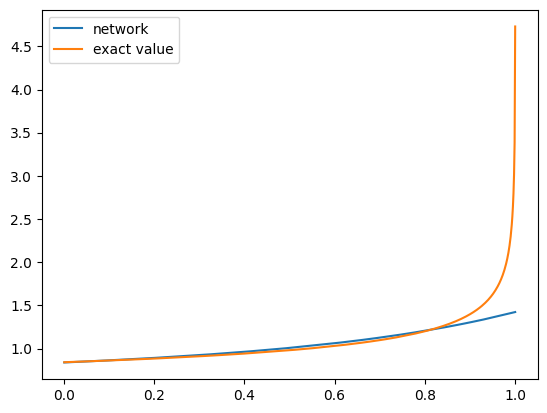

In [10]:
t_test = torch.ones(800,1)
s_test = torch.linspace(0, 1, 800).unsqueeze(1)

dt = s_test[1] - s_test[0]

input_test= torch.cat([t_test, s_test], dim=1).float()
output_test = trained_model(input_test) 
alpha = torch.tensor(0.279+0.5)
target_test = (t_test ** alpha - (t_test - s_test) ** alpha) / gamma(1 + alpha)

output_kernal = (output_test[1:] - output_test[:-1]) / dt
target_kernal = (target_test[1:] - target_test[:-1]) / dt
# plt.plot(s_test.detach().numpy(), output_test.detach().numpy(), label='network')
# plt.plot(s_test.detach().numpy(), target_test.detach().numpy(), label='exact value')
plt.plot(s_test[1:].detach().numpy(), output_kernal.detach().numpy(), label='network')
plt.plot(s_test[1:].detach().numpy(), target_kernal.detach().numpy(), label='exact value')
plt.legend()
plt.show()

In [ ]:
def train(model, inputs, targets, epochs=500, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # 目标损失函数（可以根据需要更改）

    for epoch in range(epochs):
        model.train()
        
        optimizer.zero_grad()
        
        # 正常的前向传播
        outputs, monotonic_loss = model.output_and_monotonicity_loss(inputs)
        
        # 计算标准的损失
        loss = criterion(outputs, targets)        
        
        # 总损失 = 传统损失 + 单调性损失
        total_loss = loss + monotonic_loss * torch.tensor(1e3)
        
        # 反向传播
        total_loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {total_loss.item()}')
            
    return model

In [ ]:
def gen_pretrain_data(n=252, T=1):
    t = np.linspace(0, T, T*n+1)

    tj_1 = np.tile(t[:-1], T*n).reshape(T*n, T*n)  # Times tj excluding the final point
    ti_1 = tj_1.T  # Transpose to create a grid of ti values
    tj = np.tile(t[1:], T*n).reshape(T*n, T*n)  # Times tj excluding the initial point

    alpha = 0.279+0.5 ## H=0.279

    mask = tj <= ti_1
    KK = np.zeros((T*n,T*n))
    KK[mask] = (ti_1 ** alpha - (ti_1 - tj) ** alpha)[mask] / gamma(1 + alpha)

    t_train = ti_1[mask].reshape(-1,1)
    s_train = tj[mask].reshape(-1,1)

    inputs = np.concatenate([t_train, s_train], axis=1)
    inputs = torch.tensor(inputs, dtype=torch.float32)
    outputs = KK[mask].reshape(-1,1)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    return inputs, outputs

In [ ]:
if __name__ == "__main__":
    input_dim = 2  # 输入维度
    hidden_dim = 32  # 隐藏层大小
    output_dim = 1  # 输出维度

    # 创建模型
    model = MonotonicNetwork(input_dim, hidden_dim, output_dim)

    inputs, targets = gen_pretrain_data(252, 6)
    print(f"input shape: {inputs.shape}, target shape: {targets.shape}")
    
    trained_model = train(model, inputs, targets, epochs=500, lr=0.01)

C:\Users\31251\AppData\Local\Temp\ipykernel_28832\515633575.py:12: RuntimeWarning: invalid value encountered in power
  KK[mask] = (ti_1 ** alpha - (ti_1 - tj) ** alpha)[mask] / gamma(1 + alpha)


input shape: torch.Size([1142316, 2]), target shape: torch.Size([1142316, 1])
Epoch 0/500, Loss: 0.9786930680274963
Epoch 10/500, Loss: 0.8441652059555054
Epoch 20/500, Loss: 0.7384952902793884
Epoch 30/500, Loss: 0.6491082310676575
Epoch 40/500, Loss: 0.5710719227790833
Epoch 50/500, Loss: 0.5033155679702759
Epoch 60/500, Loss: 0.44488030672073364
Epoch 70/500, Loss: 0.3942178785800934
Epoch 80/500, Loss: 0.3503314256668091
Epoch 90/500, Loss: 0.3123762905597687
Epoch 100/500, Loss: 0.279392808675766
Epoch 110/500, Loss: 0.25068342685699463
Epoch 120/500, Loss: 0.22551260888576508
Epoch 130/500, Loss: 0.20389313995838165
Epoch 140/500, Loss: 0.18410147726535797
Epoch 150/500, Loss: 0.16697372496128082
Epoch 160/500, Loss: 0.15216343104839325
Epoch 170/500, Loss: 0.13827724754810333
Epoch 180/500, Loss: 0.12619751691818237
Epoch 190/500, Loss: 0.11557074636220932
Epoch 200/500, Loss: 0.10635896772146225
Epoch 210/500, Loss: 0.09746379405260086
Epoch 220/500, Loss: 0.08994759619235992
E

In [ ]:
torch.save(trained_model.state_dict(), 'pretrain_network.pth')

In [2]:
load_model = MonotonicNetwork(2,32,1)
load_model.load_state_dict(torch.load('pretrain_network.pth', weights_only=False))
load_model.eval()

MonotonicNetwork(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc21): Linear(in_features=32, out_features=32, bias=True)
  (fc22): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
print(type(load_model))

train(load_model, inputs, targets, epochs=500, lr=0.01)

In [3]:
t_test = torch.ones(800,1)*2
s_test = torch.linspace(0, 2, 800).unsqueeze(1)

dt = s_test[1] - s_test[0]

input_test= torch.cat([t_test, s_test], dim=1).float()
output_test = load_model(input_test) 
alpha = torch.tensor(0.279+0.5)
target_test = (t_test ** alpha - (t_test - s_test) ** alpha) / gamma(1 + alpha)

output_kernal = (output_test[1:] - output_test[:-1]) / dt
target_kernal = (target_test[1:] - target_test[:-1]) / dt
plt.plot(s_test[:-1].detach().numpy(), output_kernal.detach().numpy(), label='network')
plt.plot(s_test[:-1].detach().numpy(), target_kernal.detach().numpy(), label='exact value')
plt.legend()
plt.show()

NameError: name 'gamma' is not defined